# Test neural differential equations 

Powered by [torchdiffeq](https://github.com/rtqichen/torchdiffeq), follow simple examples in [Differential Equations as a Pytorch Neural Network Layer](https://towardsdatascience.com/differential-equations-as-a-pytorch-neural-network-layer-7614ba6d587f).

In [21]:
import torch
import torch.nn as nn

from torchdiffeq import odeint

import matplotlib.pyplot as plt


class LotkaVolterra(nn.Module):
    """ 
     The Lotka-Volterra equations are a pair of first-order, non-linear, differential equations
     describing the dynamics of two species interacting in a predator-prey relationship.
    """
    def __init__(self,
                 alpha: float = 1.5, # The alpha parameter of the Lotka-Volterra system
                 beta: float = 1.0, # The beta parameter of the Lotka-Volterra system
                 delta: float = 3.0, # The delta parameter of the Lotka-Volterra system
                 gamma: float = 1.0 # The gamma parameter of the Lotka-Volterra system
                 ) -> None:
        super().__init__()
        self.model_params = torch.nn.Parameter(torch.tensor([alpha, beta, delta, gamma]), requires_grad=False)
        
        
    def forward(self, t, state):
        x = state[...,0]      #variables are part of vector array u 
        y = state[...,1]
        sol = torch.zeros_like(state)
        
        #coefficients are part of tensor model_params
        alpha, beta, delta, gamma = self.model_params    
        sol[...,0] = alpha*x - beta*x*y
        sol[...,1] = -delta*y + gamma*x*y
        return sol
    

lv_model = LotkaVolterra() #use default parameters
ts = torch.linspace(0,30.0,1000) 
batch_size = 30
# Create a batch of initial conditions (batch_dim, state_dim) as small perturbations around one value
initial_conditions = torch.tensor([[3,3]]) + 0.50*torch.randn((batch_size,2))
sol = odeint(lv_model, initial_conditions, ts)

Text(0, 0.5, 'x')

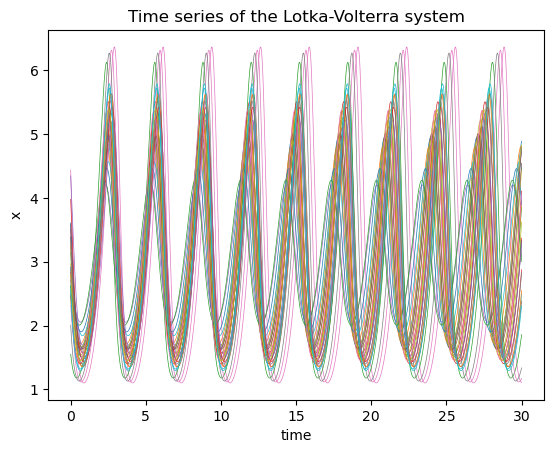

In [22]:
# Check the solution
plt.plot(ts, sol[:,:,0], lw=0.5) # type: ignore
plt.title("Time series of the Lotka-Volterra system")
plt.xlabel("time")
plt.ylabel("x")

## Preliminaries
The species and resources dynamics is given by 
$$
\frac{\mathrm{d} S_i}{\mathrm{d} t} = S_i \Big(\sum_{\alpha}G_{i\alpha}R_{\alpha} - \delta_i \Big),\\
\frac{\mathrm{d} R_{\alpha}}{\mathrm{d} t} = l_{\alpha} - R_{\alpha}\sum_{i}C_{i\alpha}S_i.
$$
Local Jacobian at fixed point is 
$$
   J^* = \left(\begin{array}{c|c}
       O  & D(S^*)G\\[1.0ex]
     \hline\\[-1.0ex]
     -D(R^*)C^\top   & - D(C^\top S^*)
    \end{array}
    \right).
$$

In [55]:
import math

class ResourceConsumption(nn.Module):
    "Resource consumption model, constant supply"
    def __init__(self,
                 G, # growth matrix
                 C, # the consumption matrix
                 delta, # mortality rate vector
                 l, # supply vector
                ):
        super(ResourceConsumption, self).__init__()
        self.Nr = G.size(dim=1)
        self.Ns = G.size(dim=0)
        self.G = nn.Parameter(G, requires_grad=False)
        self.C = nn.Parameter(C, requires_grad=False)
        self.delta = nn.Parameter(delta, requires_grad=False)
        self.l = nn.Parameter(l, requires_grad=False)
    
    def forward(self, t, state):
        species = state[...,:self.Ns] 
        resources = state[...,self.Ns:]
        dudt = torch.zeros_like(state)

        dudt[..., :self.Ns] = species*(resources @ self.G.transpose(0,1) - self.delta)
        dudt[..., self.Ns:] = self.l - resources * (species @ self.C)
        return dudt

In [68]:
Ns = 30
Nr = 32

rho = 0 # correlation

sample = torch.rand(Ns,2,Nr)
L = torch.tensor([[1, 0],
                 [rho, math.sqrt(1-rho**2)]]) # Cholesky decomposition

sample = torch.matmul(L,sample)

G = sample[0:Ns,0]
C = sample[0:Ns,1] # C has not been pushed away

C = C @ torch.diag(0.01+ 0.99*torch.rand(Nr))

Sstar = 0.01 + 0.99*torch.rand(Ns)
Rstar = 0.1 + 0.9*torch.rand(Nr)
delta = Rstar @ G.transpose(0,1)
l = Rstar*(Sstar @ C)

In [74]:
RC_model = ResourceConsumption(G,C,delta,l)
ts = torch.linspace(0,10000.0,1000) 
batch_size = 10
# Create a batch of initial conditions (batch_dim, state_dim) as small perturbations around one value
initial_conditions = (1.0 + 0.2*(torch.rand((batch_size,Ns+Nr)) - 0.5)) * torch.cat((Sstar,Rstar))
sol = odeint(RC_model, initial_conditions, ts)

Text(0, 0.5, 'x')

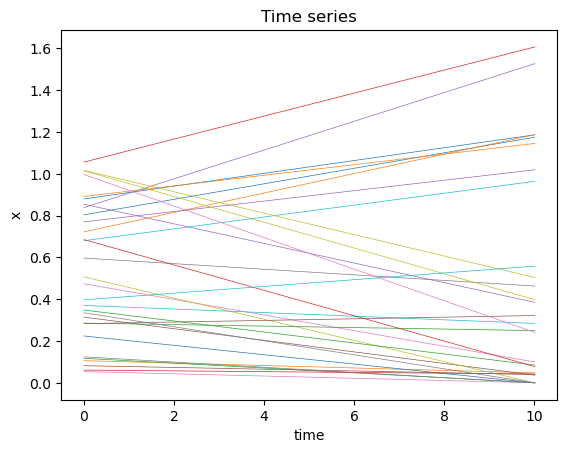

In [75]:
plt.plot(ts, sol[:,0,:Ns], lw=0.5) # type: ignore
plt.title("Time series")
plt.xlabel("time")
plt.ylabel("x")